# Simple Q-Network on Cartpole-v0 problem with Pytorch

Thanks to:  
[DQN over screenshots of Cartpole](http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)  
[tuzzer on Medium](https://medium.com/@tuzzer/follow-up-cart-pole-balancing-with-q-network-976d13f88d2f)  
[original post of CNTK](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_203_Reinforcement_Learning_Basics.ipynb)  

Some basic pieces of advice:  
* Don't forget to exclude next step Q-value of terminal state  
* Unbalanced average Q-values - increase learning_rate so they converge 
* Q-values are way bigger their stable values - increase discount factor  
* Loss is constantly increasing  
    * with Q-values? see advice above  
    * decrease learning rate  
* Average reward per game decreases slowly - make more experience replays!  
* Reward per game drops steeply - no sudden moves! clip your gradients  

## Initializing

In [1]:
%matplotlib inline

import gym
import itertools
import numpy as np
import sys
import matplotlib.pyplot as plt
import random
import math
from time import perf_counter
import os
from collections import deque

import torch
from torch import nn, optim
from torch.autograd import Variable

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)

STATE_DIM  = env.observation_space.shape[0]
NUM_ACTIONS = env.action_space.n

In [3]:
from collections import namedtuple

Transition = namedtuple('Transition',
                        ('prev_state', 'prev_action', 'state', 'reward', 'done'))

class ReplayMemory:
    
    def __init__(self, capacity):
        self.examplers = deque(maxlen=capacity)
        self.capacity = capacity
        self.rs = random.SystemRandom(0)

    def add(self, sample):
        self.examplers.append(sample)

    def get_random_samples(self, num_samples):
        num_samples = min(num_samples, len(self.examplers))
        return self.rs.sample(tuple(self.examplers), num_samples)

mem = ReplayMemory(3)
for i in range(6):
    mem.add(i)
    print(mem.get_random_samples(3))
    

np.random.seed(0)
trans = [Transition(*x) for x in zip(np.random.normal(0,1,size=(2,STATE_DIM)), 
        np.arange(2), 
        np.random.normal(0,1,size=(2,STATE_DIM)), 
        np.arange(2), 
        np.arange(2))]
trans

[0]
[0, 1]
[0, 2, 1]
[1, 3, 2]
[2, 4, 3]
[5, 3, 4]


[Transition(prev_state=array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ]), prev_action=0, state=array([-0.10321885,  0.4105985 ,  0.14404357,  1.45427351]), reward=0, done=0),
 Transition(prev_state=array([ 1.86755799, -0.97727788,  0.95008842, -0.15135721]), prev_action=1, state=array([ 0.76103773,  0.12167502,  0.44386323,  0.33367433]), reward=1, done=1)]

In [4]:
def grad_clipping(parameters, clip=10):
    for p in parameters:
        g = (p.grad.data ** 2).mean()
        if g > clip:
            p.grad.data *= clip / g
            
            
class Brain:

    BATCH_SIZE = 100
    DISCOUNT_FACTOR = 0.9
    
    LEARNING_RATE = 5e-5
    CLIP = 1e-1
    
    def __init__(self):
        #### Construct the model ####
        torch.manual_seed(0)
        sizes = [STATE_DIM]+ [128]
        layers = []
        for i, (prev_size, size) in enumerate(zip(sizes[:-1], sizes[1:])):
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
        
        final_l = nn.Linear(size, NUM_ACTIONS)
        layers.append(final_l)
        self.model = nn.Sequential(*layers)

        #### Define optimizer ####
        self.optimizer = optim.Adam(self.model.parameters(), 
                                    lr=self.LEARNING_RATE, 
                                    betas=(0.9, 0.999))

    def train(self, prev_states, prev_actions, states, rewards, dones):
        q_action = self._predict_torch(np.array(prev_states))
        next_best_q = self._predict_torch(np.array(states)).max(1)[0].data
        rewards_t = torch.FloatTensor(np.array(rewards))
        dones_t = torch.FloatTensor(np.array(dones).astype(float))
        delta = rewards_t + (1-dones_t) * self.DISCOUNT_FACTOR * next_best_q
        self.model.train()
        # selected_q_actions = q_action[:,torch.LongTensor(np.array(prev_actions).astype(int))]
        selected_q_actions = q_action.gather(1,Variable(torch.LongTensor(
                                                np.array(prev_actions).astype(int)
                                                )).view(-1,1))
        loss =  ((selected_q_actions - Variable(delta.view(-1,1), requires_grad = False)) ** 2).mean()
        # loss = nn.modules.loss.SmoothL1Loss()\
        #    (selected_q_actions, Variable(delta.view(-1,1), requires_grad = False))
        self.model.zero_grad()
        loss.backward()
        grad_clipping(self.model.parameters(), clip=self.CLIP)
        self.optimizer.step()
        return loss.data.numpy()[0] #, q_action.mean(0).data.numpy()

    def _predict_torch(self, states):
        self.model.eval()
        state_var = Variable(torch.Tensor(states))
        preds = self.model(state_var)
        return preds

    def predict(self, state):
        preds = self._predict_torch(state.reshape(1,-1))
        return preds.data.numpy()[0]

    
np.random.seed(0)
b = Brain()
state = np.random.normal(0,1,size=STATE_DIM)
print(b.predict(state))
b.train(*zip(*trans))

[ 0.25155476 -0.31935942]


0.59749997

In [5]:
class Agent:

    MEMORY_CAPACITY = 100000
    MAX_EXPLORATION_RATE = 1.0
    MIN_EXPLORATION_RATE = 0.05
    DECAY_RATE = 0.0001
    REPLAY_EACH_STEP = 2

    def __init__(self):
        self.explore_rate = self.MAX_EXPLORATION_RATE
        self.hist = {k:[] for k in ['actions', 'reward', 'loss', 'q_vals']}
        self.brain = Brain()
        self.memory = ReplayMemory(self.MEMORY_CAPACITY)
        self.steps = 0
        self.rs = random.SystemRandom(0)

    def act(self, s):
        pred_q = self.brain.predict(s)
        self.hist['q_vals'].append(pred_q)
        if self.rs.random() < self.explore_rate:
            act =  self.rs.randint(0, NUM_ACTIONS - 1)
        else:
            act = np.argmax(pred_q)
        self.hist['actions'].append(act)
        return act

    def observe(self, sample):
        self.steps += 1
        self.memory.add(sample)
        # Reduces exploration rate linearly
        self.explore_rate = self.MIN_EXPLORATION_RATE + \
                (self.MAX_EXPLORATION_RATE - self.MIN_EXPLORATION_RATE) * \
                    math.exp(-self.DECAY_RATE * self.steps)

    def _replay(self):
        batch = self.memory.get_random_samples(self.brain.BATCH_SIZE)
        prev_states, prev_actions, states, rewards, dones = zip(*batch)
        loss = self.brain.train(prev_states, prev_actions, states, rewards, dones)
        self.hist['loss'].append(loss)
        return loss
    
    def replay(self):
        for i in range(self.REPLAY_EACH_STEP):
            loss = self._replay()
            self.hist['loss'].append(loss)
        return loss
    
    
a = Agent()

a.observe(trans[0])
a.replay()
a.act(trans[0].state)
a.hist

{'actions': [1],
 'loss': [0.10584649, 0.10584649, 0.10459135, 0.10459135],
 'q_vals': [array([-0.08536449, -0.19556978], dtype=float32)],
 'reward': []}

In [6]:
from itertools import count

def run_simulation(agent, solved_reward_level):
    state = env.reset()
    total_rewards = 0
    for step in count():
        # env.render()
        action = agent.act(state.astype(np.float32))
        
        next_state, reward, done, info = env.step(action)
        
        agent.observe(Transition(state, action, next_state, reward, done))
        for _ in range(2):
            agent.replay()

        state = next_state
        total_rewards += reward

        if total_rewards > solved_reward_level or done:
            agent.hist['reward'].append(total_rewards)
            return total_rewards, step

a = Agent()
run_simulation(a, 200)
a.hist['q_vals'][:5]

[array([ 0.00035731, -0.06772216], dtype=float32),
 array([ 0.0235    , -0.00591575], dtype=float32),
 array([ 0.0019551 , -0.06129389], dtype=float32),
 array([ 0.02950168,  0.00023249], dtype=float32),
 array([ 0.00833715, -0.05467951], dtype=float32)]

## Training

In [7]:
MAX_NUM_EPISODES = 1000
STREAK_TO_END = 120
DONE_REWARD_LEVEL = 196

np.random.seed(0)

agent = Agent()
env = gym.make('CartPole-v0')
env.seed(0)

PRINT_PROGRESS_EACH_SIMULATIONS = 50

episode_number = 0
reward_sum = 0
step_cnt = 0
num_streaks = 0
solved_episode = -1

training_start_time = perf_counter()
while episode_number < MAX_NUM_EPISODES:

    # Run the simulation and train the agent
    reward, step = run_simulation(agent, DONE_REWARD_LEVEL*2)
    reward_sum += reward
    step_cnt += step
    episode_number += 1
    if episode_number % PRINT_PROGRESS_EACH_SIMULATIONS == 0:
        t = perf_counter() - training_start_time
        print(("(%ds) Ep: %d, " +
               "reward = %0.4f, " + 
               "loss = %0.4f, " + 
               "expl_r = %0.4f, " + 
               "right share = %0.4f, " + 
               "q aver = %s") % \
                  (t, episode_number, 
                   reward_sum / PRINT_PROGRESS_EACH_SIMULATIONS, 
                   sum(agent.hist['loss'][-step_cnt:]) / step_cnt,
                   agent.explore_rate, 
                   sum(agent.hist['actions'][-step_cnt:]) / step_cnt,
                   "%0.2f - %0.2f" % tuple(sum(agent.hist['q_vals'][-step_cnt:]) / step_cnt)
                  ))
        reward_sum = 0
        step_cnt = 0

    # It is considered solved when the sum of reward is over 200
    if reward > DONE_REWARD_LEVEL:
        num_streaks += 1
        solved_episode = episode_number
    else:
        num_streaks = 0
        solved_episode = -1

    # It's considered done when it's solved over 120 times consecutively
    if num_streaks > STREAK_TO_END:
        print("Task solved in %d episodes and repeated %d times." % \
                  (episode_number, num_streaks))
        break


(5s) Ep: 50, reward = 18.8600, loss = 3.4615, expl_r = 0.9145, right share = 0.4994, q aver = 3.13 - 3.24
(11s) Ep: 100, reward = 18.0200, loss = 3.1985, expl_r = 0.8400, right share = 0.5969, q aver = 8.03 - 9.04
(21s) Ep: 150, reward = 27.6200, loss = 1.5318, expl_r = 0.7381, right share = 0.4718, q aver = 7.72 - 7.72
(32s) Ep: 200, reward = 33.0600, loss = 1.4685, expl_r = 0.6333, right share = 0.4953, q aver = 8.83 - 8.83
(51s) Ep: 250, reward = 56.5000, loss = 1.1653, expl_r = 0.4897, right share = 0.5038, q aver = 9.63 - 9.63
(109s) Ep: 300, reward = 160.7400, loss = 0.5142, expl_r = 0.2469, right share = 0.4991, q aver = 10.25 - 10.26
(187s) Ep: 350, reward = 200.0000, loss = 0.4322, expl_r = 0.1224, right share = 0.4981, q aver = 10.51 - 10.50
(269s) Ep: 400, reward = 200.0000, loss = 0.4017, expl_r = 0.0766, right share = 0.5043, q aver = 10.42 - 10.42
Task solved in 410 episodes and repeated 121 times.


## History overview

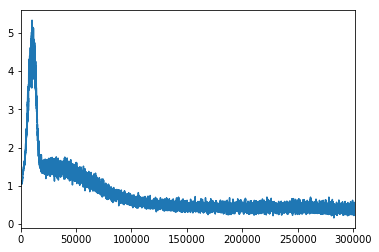

In [8]:
import pandas as pd

pd.Series(agent.hist['loss']).rolling(100).mean().plot()

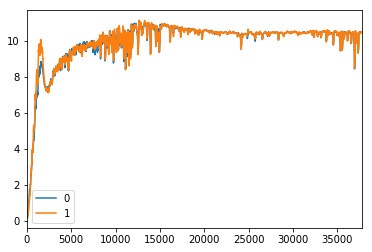

In [9]:
pd.DataFrame(agent.hist['q_vals']).rolling(100).mean().plot()

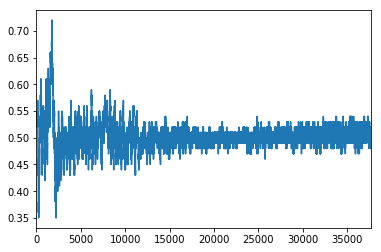

In [10]:
pd.Series(agent.hist['actions']).rolling(100).mean().plot()

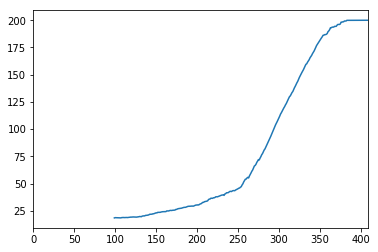

In [11]:
pd.Series(agent.hist['reward']).rolling(100).mean().plot()